In [2]:
import sys
import os
import numpy as np

import timeit
sys.path.append('/Users/zhouji/Google Drive/RWTH/GP_old')


import matplotlib.pyplot as plt
import gempy as gp
from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from gempy import create_data, map_series_to_surfaces
from gempy.assets.geophysics import GravityPreprocessing
tfd = tfp.distributions

def Plot_2D_scaler_field(grid, scaler_field):
    G = grid[np.where(grid[:, 1] == [grid[-1][1]])[0]]
    S = scaler_field.numpy()[np.where(grid[:, 1] == [grid[0][1]])[0]]
    XX = G[:, 0].reshape([50, 50])
    ZZ = G[:, 2].reshape([50, 50])
    S = S.reshape([50, 50])
    plt.contour(XX, ZZ, S)

path = '/Users/zhouji/Google Drive/RWTH/GP_old/notebooks/'
geo_data = create_data([0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                 path_o=path+ "/data/input_data/George_models/model2_1_orientations.csv",
                  path_i=path + "/data/input_data/George_models/180surface_points.csv",
             default_values=True)
map_series_to_surfaces(geo_data, {"Strat_Series": (
    'rock2', 'rock1'), "Basement_Series": ('basement')})

geo_data.add_surface_values([2.61, 3.1, 2.92])

# Gravity test
# ---------
grav_res = 15
X = np.linspace(0, 1000, grav_res)
Y = np.linspace(0, 1000, grav_res)
Z = 300
xyz = np.meshgrid(X, Y, Z)
xy_ravel = np.vstack(list(map(np.ravel, xyz))).T

geo_data.set_centered_grid(xy_ravel, resolution=[10, 10, 20], radius=2000)
interpolator = geo_data.interpolator
dtype = interpolator.additional_data.options.df.loc['values', 'dtype']
dtype = 'float32'

# extract data from gempy interpolator
_, dip_angles, azimuth, polarity, surface_points_coord, fault_drift, grid, values_properties = interpolator.get_python_input_block()[
    0:-3]
dip_angles = tf.cast(dip_angles,dtype)
grid = tf.cast(grid,dtype)
dips_position = tf.cast(dips_position,dtype)
azimuth = tf.cast(azimuth,dtype)
polarity = tf.cast(polarity,dtype)
fault_drift = tf.cast(fault_drift,dtype)
values_properties = tf.cast(values_properties,dtype)


centers = geo_data.rescaling.df.loc['values', 'centers'].astype(dtype)


g = GravityPreprocessing(geo_data.grid.centered_grid)
tz = g.set_tz_kernel()

tz = tf.cast(tz,dtype)

len_rest_form = interpolator.additional_data.structure_data.df.loc[
    'values', 'len surfaces surface_points'] - 1
Range = interpolator.additional_data.kriging_data.df.loc['values', 'range']
C_o = interpolator.additional_data.kriging_data.df.loc['values', '$C_o$']
rescale_factor = interpolator.additional_data.rescaling_data.df.loc[
    'values', 'rescaling factor']

# rf = rescale_factor
nugget_effect_grad = np.cast[dtype](
    np.tile(interpolator.orientations.df['smooth'], 3))
nugget_effect_scalar = np.cast[dtype](
    interpolator.surface_points.df['smooth'])

TFG = TFGraph(dip_angles, azimuth,
              polarity, fault_drift,
              grid, values_properties, len_rest_form, Range,
              C_o, nugget_effect_scalar, nugget_effect_grad,
              rescale_factor)

surface_points_coord = tf.convert_to_tensor(surface_points_coord)

mu_true = geo_data.surface_points.df.loc[Number_para:,'Z'].to_numpy()
mu_true = tf.convert_to_tensor(mu_true,tfdtype)
Z_coord = tf.expand_dims(tf.concat([((mu_true-thickness-centers[2])/rf+0.5001),((mu_true-centers[2])/rf+0.5001)],axis=0),axis=1)
surface_coord =tf.concat([surface_points_coord[:,:2],Z_coord],axis = 1)
dips_position = tf.gather(surface_coord,indexes)

Z_x = TFG.scalar_field(surface_points_coord,dips_position)


scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
formations_block = TFG.export_formation_block(
    Z_x, scalar_field_at_surface_points, values_properties)

lg_0 = interpolator.grid.get_grid_args('centered')[0]
lg_1 = interpolator.grid.get_grid_args('centered')[1]
dips_position = tf.convert_to_tensor(dips_position,dtype=dtype)
dip_angles = tf.convert_to_tensor(dip_angles,dtype=dtype)
azimuth = tf.convert_to_tensor(azimuth,dtype=dtype)
polarity = tf.convert_to_tensor(polarity,dtype=dtype)

fault_drift = tf.convert_to_tensor(fault_drift,dtype=dtype)
grid = tf.convert_to_tensor(grid,dtype=dtype)
values_properties = tf.convert_to_tensor(values_properties,dtype=dtype)
len_rest_form = tf.convert_to_tensor(len_rest_form,dtype=dtype)
Range = tf.convert_to_tensor(Range, dtype)
C_o = tf.convert_to_tensor(C_o,dtype=dtype)
nugget_effect_grad = tf.convert_to_tensor(nugget_effect_grad,dtype=dtype)
nugget_effect_scalar = tf.convert_to_tensor(nugget_effect_scalar,dtype=dtype)
rescale_factor = tf.convert_to_tensor(rescale_factor, dtype)

densities = formations_block[1][lg_0:lg_1]

## Plot the ground truth
grav = TFG.compute_forward_gravity(tz, lg_0, lg_1, densities)
Data = grav

Active grids: ['centered']
Active grids: ['centered']


AttributeError: additional_data

In [ ]:
xx, yy = np.meshgrid(X, Y)
gravity = tf.reshape(grav, [grav_res, grav_res])
gp.plot.plot_data(geo_data, direction='z',)
ax = plt.gca()
ax.scatter(xy_ravel[:, 0], xy_ravel[:, 1], s=10, zorder=1)
ax.contourf(xx, yy, gravity, zorder=-1)

In [4]:
regular = interpolator.grid.get_grid_args('regular')

In [5]:
regular_grid = grid[regular[0]:regular[1]]

In [6]:
regular_scalar = Z_x[regular[0]:regular[1]]

In [7]:
meshgrid = np.reshape(regular_scalar,geo_data.grid.regular_grid.resolution)

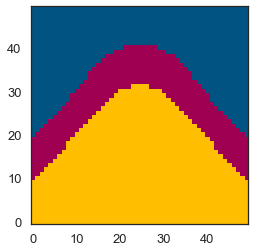

In [8]:
import matplotlib.colors as mcolors

lith_block = np.round(formations_block[0][regular[0]:regular[1]])
_block = lith_block
color = geo_data.surfaces.df['color']
cmap = mcolors.ListedColormap(list(color))

plot_block = _block.reshape(geo_data.grid.regular_grid.resolution)

sliced_block = plot_block[:, 15, :].T
im = plt.imshow(sliced_block,origin="bottom",aspect = 1,cmap=cmap)


In [9]:
-2 * TFG.len_points, -TFG.len_points

(-68, -34)

In [10]:
partitions = tf.reduce_sum(tf.one_hot(TFG.npf,TFG.len_points,dtype = 'int32'),axis = 0)
scalar_field_at_surface_points_values = tf.dynamic_partition(Z_x[-2 * TFG.len_points: -TFG.len_points],partitions,2)[1]

In [11]:
scalar_field_at_surface_points_values

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.42504378, 0.57349505])>

In [12]:
def fullprint(*args, **kwargs):
  from pprint import pprint
  import numpy
  opt = numpy.get_printoptions()
  numpy.set_printoptions(threshold=numpy.inf)
  pprint(*args, **kwargs)
  numpy.set_printoptions(**opt)

In [70]:
fullprint(Z_x)

<tf.Tensor: shape=(125068,), dtype=float64, numpy=
array([0.2215319 , 0.23347501, 0.24562812, 0.2580024 , 0.27060861,
       0.28345704, 0.29655735, 0.30991843, 0.32354817, 0.3374533 ,
       0.35163911, 0.36610915, 0.38086489, 0.3959053 , 0.41122639,
       0.4268207 , 0.44267673, 0.45877842, 0.47510464, 0.49162882,
       0.5083188 , 0.52513701, 0.54204096, 0.55898419, 0.57591755,
       0.59279094, 0.60955512, 0.62616388, 0.64257602, 0.65875725,
       0.67468158, 0.69033224, 0.70570183, 0.72079176, 0.73561126,
       0.75017589, 0.76450598, 0.77862504, 0.79255837, 0.80633181,
       0.81997081, 0.83349966, 0.84694097, 0.8603153 , 0.87364098,
       0.88693397, 0.90020788, 0.91347408, 0.92674178, 0.94001819,
       0.22085105, 0.23279511, 0.244952  , 0.25733313, 0.26994957,
       0.28281192, 0.29593018, 0.30931358, 0.32297043, 0.33690787,
       0.35113162, 0.36564571, 0.38045205, 0.39555008, 0.41093622,
       0.42660334, 0.44254019, 0.45873074, 0.47515367, 0.49178194,
       0.50

In [30]:
xx, yy = np.meshgrid(X, Y)
gravity = tf.reshape(grav, [grav_res, grav_res])
gp.plot.plot_data(geo_data, direction='z',)
ax = plt.gca()
ax.scatter(xy_ravel[:, 0], xy_ravel[:, 1], s=10, zorder=1)
ax.contourf(xx, yy, gravity, zorder=-1)

NameError: name 'X' is not defined

## Bayesian model

In [3]:
centers = tf.convert_to_tensor(centers,dtype=tf.float64)

In [16]:
thickness = tf.constant(200,dtype = tf.float64) # here just keep thickness constant
Number_para = int(surface_points_coord.shape[0]/2)
mu_prior = 600 * tf.ones(Number_para, dtype=tf.float64) 
sigma = 100
## covariance = sigma ^2
cov_prior = sigma ** 2 * tf.eye(Number_para, dtype=tf.float64)
cov = 0.08 * tf.eye(grav.shape[0],dtype = tf.float64)

# rescale the prior
mu_prior_r = (mu_prior-centers[2])/rf+0.5001
cov_prior_r = ((sigma)/rf)**2 * tf.eye(Number_para, dtype=tf.float64) #$$# double check here

NameError: name 'rf' is not defined

### Create some noisy data

In [14]:
mu_true = geo_data.surface_points.df.loc[Number_para:,'Z'].to_numpy()
mu_true = tf.convert_to_tensor(mu_true,tf.float64)

NameError: name 'Number_para' is not defined

In [15]:
mu = mu_true+tf.random.normal(mu_true.shape,mean = 0,stddev=5,dtype=dtype)
Z_coord = tf.expand_dims(tf.concat([((mu-thickness-centers[2])/rf+0.5001),((mu-centers[2])/rf+0.5001)],axis=0),axis=1)
surface_coord =tf.concat([surface_points_coord[:,:2],Z_coord],axis = 1)
grav = calculate_grav(surface_coord)
gravity = tf.reshape(grav, [grav_res, grav_res])
gp.plot.plot_data(geo_data, direction='z',)
ax = plt.gca()
ax.scatter(xy_ravel[:, 0], xy_ravel[:, 1], s=10, zorder=1)
ax.contourf(xx, yy, gravity, zorder=-1)

NameError: name 'mu_true' is not defined

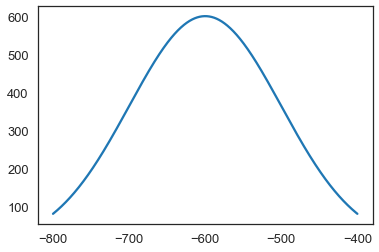

In [33]:
x = np.linspace(-800, -400, 1000)
plt.plot(x,mu_prior[5]*np.exp(-0.5*((x+mu_prior[5])/sigma)**2))

In [35]:
# calculate the gravity with a set of given surface coordinate
@tf.function
def calculate_grav(surface_coord):
    TFG = TFGraph(dips_position, dip_angles, azimuth,
              polarity, fault_drift,
              grid, values_properties, len_rest_form, Range,
              C_o, nugget_effect_scalar, nugget_effect_grad,
              rescale_factor)
    Z_x = TFG.scalar_field(surface_coord)

    scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
    formations_block = TFG.export_formation_block(
        Z_x, scalar_field_at_surface_points, values_properties)

    densities = formations_block[1][lg_0:lg_1]

    gravity = TFG.compute_forward_gravity(tz, lg_0, lg_1, densities)

    return gravity

In [36]:
@tf.function
def joint_log_post(Data, mu):
    """[summary]

    Arguments:
        Data {[Tensor]} -- [description]
        _control_position {[Tensor]} -- [description]cov_prior_r = ((sigma-centers[2])/rf+0.5001)**2 * tf.eye(Number_para, dtype=tf.float32)

    Returns:
        [type] -- [description]
    """
    
    Z_coord = tf.expand_dims(tf.concat([((mu-thickness-centers[2])/rf+0.5001),((mu-centers[2])/rf+0.5001)],axis=0),axis=1)
    surface_coord =tf.concat([surface_points_coord[:,:2],Z_coord],axis = 1)

    # define prior distribution
    mvn_prior = tfd.MultivariateNormalTriL(
        loc=mu_prior_r,
        scale_tril = tf.linalg.cholesky(cov_prior_r))
        
    # define likelihood
    Gm_ = calculate_grav(surface_coord)

    mvn_likelihood = tfd.MultivariateNormalTriL(
        loc=Gm_,
        scale_tril=tf.linalg.cholesky(cov))

    # return the posterior probability
    return (mvn_prior.log_prob(tf.squeeze(Z_coord[Number_para:]))
                + mvn_likelihood.log_prob(Data))

In [37]:
@tf.function
def negative_log_posterior(Data, surface_coord):
    return tf.negative(joint_log_post(Data, surface_coord))

In [38]:
joint_log_post(Data,mu_prior)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


<tf.Tensor: shape=(), dtype=float64, numpy=85.11636831239235>

In [39]:
mu = tf.random.normal(mu_prior.shape,mean = 600,stddev=100,dtype=dtype)

In [40]:
Z_coord = tf.expand_dims(tf.concat([((mu-thickness-centers[2])/rf+0.5001),((mu-centers[2])/rf+0.5001)],axis=0),axis=1)
surface_coord =tf.concat([surface_points_coord[:,:2],Z_coord],axis = 1)

In [42]:
start = timeit.default_timer()
with tf.GradientTape(watch_accessed_variables=False) as t:
    t.watch(mu)
    loss = joint_log_post(Data,mu)
grad = t.gradient(loss,mu)
print(grad)

end = timeit.default_timer()
print('time for gradient calculation: %.3f' % (end - start))

tf.Tensor(
[ 3319.36025299 -3823.34228264   432.12041128  -389.60662305
  -524.81277736   242.58594982  2654.45543328  -848.9475051
  -438.50262513 -6217.46259972  5746.91677693  -133.52002248
 -2409.29931327  -217.47889119    80.65802703   114.1356445
   737.25408104  -238.18783915], shape=(18,), dtype=float64)
time for gradient calculation: 12.145


#### gradient check by finite difference

it seems take quite long to calculate gradient, let's check if the gradient is correct

This is not accurate by FD, because of the precision

In [21]:
grad_fd = np.empty([Number_para])
for i in range(Number_para):

    h = np.zeros_like(mu)
    h[i] = 0.001
    f_xh = joint_log_post(Data,(mu + h)) - joint_log_post(Data,(mu - h))

    dfx_dx = np.sum(f_xh/(2*h[i]))
    grad_fd[i]=dfx_dx

In [22]:
print(grad_fd)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Find MAP

##### SGD

In [23]:
def loss(mu):
    lost =  negative_log_posterior(Data,mu)
    return lost

def loss_minimize():
    lost =  negative_log_posterior(Data,mu)
    return lost

In [26]:
tf.random.set_seed(1)
mu_init = tf.random.normal(mu_prior.shape,mean = 600,stddev=100,dtype=dtype)

In [27]:
mu = tf.Variable(mu_init)
loss(mu).numpy()

36443.527

In [ ]:
cost = []
mu = tf.Variable(mu_init)
opt = tf.keras.optimizers.SGD(learning_rate=0.001, name='SGD')
steps = 100
start = timeit.default_timer()
for i in range(steps):
    opt.minimize(loss_minimize, var_list=[mu])
    cost.append(loss(mu).numpy())
    print ('step:',len(cost),'loss',loss(mu).numpy())
end = timeit.default_timer()
print('SGD: %.3f' % (end - start))

result_100_SGD = loss(mu).numpy()

In [ ]:
mu

##### Adam

In [ ]:
tf.random.set_seed(1)
mu_init = tf.random.normal(mu_prior.shape,mean = 600,stddev=100,dtype=dtype)

In [ ]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.1
)
cost_A = []
mu = tf.Variable(mu_init)
start = timeit.default_timer()
for step in range(1000):
# while loss(mu) > -22:
    Adam.minimize(loss_minimize, var_list=[mu])
    cost_A.append(loss(mu).numpy())
    print ('step:',step,'loss',loss(mu).numpy())
end = timeit.default_timer()
print('Adam: %.3f' % (end - start))
MAP = mu


In [ ]:
MAP

In [ ]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float64, size=Number_para)
    j=0
    for i in range(Number_para):
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = negative_log_posterior(Data,MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return Hess.stack()
New_Hessian = Full_Hessian()

In [42]:
mu_true = geo_data.surface_points.df.loc[Number_para:,'Z'].to_numpy()

In [43]:
mu_true

array([400, 400, 400, 400, 400, 400, 800, 800, 800, 600, 600, 600, 800,
       800, 800, 600, 600, 600])

In [45]:
aa = np.nan

# Profiling 

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime

In [ ]:
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)


joint_log_post(Data,mu_prior)

tf.summary.trace_on(graph=True, profiler=True)

with writer.as_default():
    tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

In [ ]:
%reload_ext tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/func

In [ ]:
import sys
import os
import numpy as np

import timeit
sys.path.append("/Users/zhouji/Documents/github/gempy")


import matplotlib.pyplot as plt
import gempy as gp
from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from gempy import create_data, map_series_to_surfaces
from gempy.assets.geophysics import GravityPreprocessing
tfd = tfp.distributions

def Plot_2D_scaler_field(grid, scaler_field):
    G = grid[np.where(grid[:, 1] == [grid[-1][1]])[0]]
    S = scaler_field.numpy()[np.where(grid[:, 1] == [grid[0][1]])[0]]
    XX = G[:, 0].reshape([50, 50])
    ZZ = G[:, 2].reshape([50, 50])
    S = S.reshape([50, 50])
    plt.contour(XX, ZZ, S)

path = '/Users/zhouji/Documents/github/gempy/notebooks/'
geo_data = create_data([0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                       path_o=path+ "/data/input_data/jan_models/model2_orientations.csv",
                       path_i=path + "/data/input_data/jan_models/model2_surface_points.csv")
map_series_to_surfaces(geo_data, {"Strat_Series": (
    'rock2', 'rock1'), "Basement_Series": ('basement')})

geo_data.add_surface_values([2.61, 3.1, 2.92])

# Gravity test
# ---------
grav_res = 20
X = np.linspace(0, 1000, grav_res)
Y = np.linspace(0, 1000, grav_res)
Z = 300
xyz = np.meshgrid(X, Y, Z)
xy_ravel = np.vstack(list(map(np.ravel, xyz))).T


geo_data.set_centered_grid(xy_ravel, resolution=[10, 10, 15], radius=5000)
interpolator = geo_data.interpolator
dtype = interpolator.additional_data.options.df.loc['values', 'dtype']

dips_position, dip_angles, azimuth, polarity, surface_points_coord, fault_drift, grid, values_properties = interpolator.get_python_input_block()[
    0:-3]

centers = geo_data.rescaling.df.loc['values', 'centers'].astype('float32')


g = GravityPreprocessing(geo_data.grid.centered_grid)
tz = g.set_tz_kernel()

len_rest_form = interpolator.additional_data.structure_data.df.loc[
    'values', 'len surfaces surface_points'] - 1
Range = interpolator.additional_data.kriging_data.df.loc['values', 'range']
C_o = interpolator.additional_data.kriging_data.df.loc['values', '$C_o$']
rescale_factor = interpolator.additional_data.rescaling_data.df.loc[
    'values', 'rescaling factor']

rf = rescale_factor
nugget_effect_grad = np.cast[dtype](
    np.tile(interpolator.orientations.df['smooth'], 3))
nugget_effect_scalar = np.cast[interpolator.dtype](
    interpolator.surface_points.df['smooth'])

surface_points_coord = tf.Variable(surface_points_coord, dtype=tf.float32)


TFG = TFGraph(dips_position, dip_angles, azimuth,
              polarity, fault_drift,
              grid, values_properties, len_rest_form, Range,
              C_o, nugget_effect_scalar, nugget_effect_grad,
              rescale_factor)

In [ ]:
tf.reduce_sum(tf.one_hot(TFG.npf,tf.shape(Z_x)[0],dtype = 'int32'),axis = 0)

In [ ]:
TFG.get_scalar_field_at_surface_points(Z_x)

In [ ]:
TFG.get_scalar_field_at_surface_points(Z_x)

In [ ]:
partitions = tf.reduce_sum(tf.one_hot(TFG.npf,TFG.len_points,dtype = 'int32'),axis = 0)

In [ ]:
scalar_field_at_surface_points_values = tf.dynamic_partition(Z_x[-2 * TFG.len_points: -TFG.len_points],partitions,2)[1]